# Datenverarbeitung mit Python — Eine Einführung

**Eckhard Kadasch**, 
Klaus Pankatz

Deutscher Wetterdienst, Zentrales Klimabüro

*DACH Meteorologentagung, 18.-22. März 2019, Garmisch-Partenkirchen*

<img src="./fig/dwd-logo.svg"
     align="right"
     width="30%"
     alt="Deutscher Wetterdienst">

## Überblick

1. Daten lesen
   - CSV
   - NetCDF
2. Plotting
3. Kartenprojektionen

## CSV-Dateien lesen

In [1]:
!head ./data/temperatures.csv

time "temperature (Berlin)" "temperature (Hamburg)" "temperature (Garmisch-Partenkirchen)"
2018-01-01 3.2 -6.1 -5.5
2018-01-02 0.0 -5.4 -0.1
2018-01-03 -5.6 -9.9 -7.8
2018-01-04 nan -2.5 -3.7
2018-01-05 nan -8.5 -2.1
2018-01-06 -3.2 -8.0 -2.6
2018-01-07 -5.8 -12.1 0.5
2018-01-08 1.7 -7.3 0.2
2018-01-09 -3.9 -9.1 -7.9


In [2]:
import numpy

fname = './data/temperatures.csv'
temperature = numpy.genfromtxt(fname, delimiter=' ', skip_header=1, usecols=(1,2,3))

In [3]:
print(temperature.shape)

(365, 3)


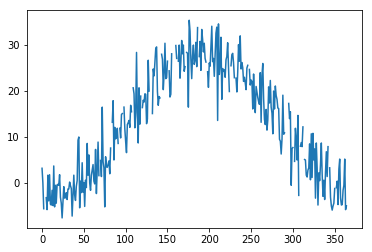

In [4]:
from matplotlib import pyplot
%matplotlib inline

pyplot.plot(temperature[:,0])

## CSV-Dateien mit Pandas lesen

In [5]:
import pandas
fname = './data/temperatures.csv'
df = pandas.read_csv(fname, delimiter=' ', usecols=(0,1,2,3),
                     parse_dates=['time'], index_col=0)

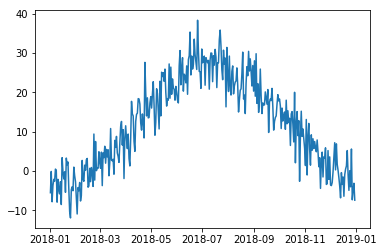

In [6]:
pyplot.plot( df['temperature (Garmisch-Partenkirchen)'] )

## Datumsbasierte Aggregation

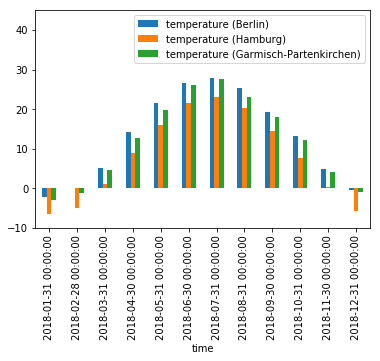

In [7]:
monthly_mean = df.resample('M').mean()
monthly_mean.plot.bar(ylim=(-10, 45))

Die verfügbaren Resampling-Raten findet man in der [Pandas-Dokumentation](http://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#offset-aliases).

## NetCDF-Dateien lesen

NetCDF ist ein selbstbeschreibendes, binäres Datenformat für mehrdimensionale Datenfelder.

In [8]:
!cat ./data/nc_dump.log

netcdf cosmo-d2_germany_rotated-lat-lon_single-level_2019020512_000_T_2M {
dimensions:
	time = UNLIMITED ; // (1 currently)
	rlon = 651 ;
	rlat = 716 ;
	height = 1 ;
variables:
	double time(time) ;
		time:standard_name = "time" ;
		time:units = "hours since 2019-2-5 12:00:00" ;
        ...
	float rlon(rlon) ;
		rlon:standard_name = "grid_longitude" ;
		rlon:long_name = "longitude in rotated pole grid" ;
		rlon:units = "degrees" ;
		rlon:axis = "X" ;
	float rlat(rlat) ;
		rlat:standard_name = "grid_latitude" ;
        ...
	float \2t(time, height, rlat, rlon) ;
		\2t:standard_name = "air_temperature" ;
		\2t:long_name = "2 metre temperature" ;
		\2t:units = "K" ;
		\2t:param = "0.0.0" ;
		\2t:grid_mapping = "rotated_pole" ;
        ...
}

### NetCDF Variablen lesen

In [9]:
from netCDF4 import Dataset

filename = './data/cosmo-d2_germany_rotated-lat-lon_single-level_2019020512_000_T_2M.nc'
ds = Dataset(filename, 'r')

# Variablen -> .variables
rlon = ds.variables['rlon'][:]
rlat = ds.variables['rlat'][:]
t_2m = ds.variables['2t'][:]

print('Shape :', t_2m.shape)

Shape : (1, 1, 716, 651)


### Metadaten lesen

In [10]:
# Variablen-Attribute -> .variables[<name>].<attribute>
t_2m_name = ds.variables['2t'].long_name
t_2m_unit = ds.variables['2t'].units
print('%s  [%s]' %(t_2m_name, t_2m_unit))

ds.close()

2 metre temperature  [K]


### Multifile Datensätze

In [11]:
from netCDF4 import MFDataset

In [12]:
# List comprehension: [expression + for clause]
nc_files = ['./data/cosmo-d2_germany_rotated-lat-lon_single-level_2019020512_%03i_T_2M.nc' % hour
            for hour in range(0, 27+3, 3)]
nc_files

['./data/cosmo-d2_germany_rotated-lat-lon_single-level_2019020512_000_T_2M.nc',
 './data/cosmo-d2_germany_rotated-lat-lon_single-level_2019020512_003_T_2M.nc',
 './data/cosmo-d2_germany_rotated-lat-lon_single-level_2019020512_006_T_2M.nc',
 './data/cosmo-d2_germany_rotated-lat-lon_single-level_2019020512_009_T_2M.nc',
 './data/cosmo-d2_germany_rotated-lat-lon_single-level_2019020512_012_T_2M.nc',
 './data/cosmo-d2_germany_rotated-lat-lon_single-level_2019020512_015_T_2M.nc',
 './data/cosmo-d2_germany_rotated-lat-lon_single-level_2019020512_018_T_2M.nc',
 './data/cosmo-d2_germany_rotated-lat-lon_single-level_2019020512_021_T_2M.nc',
 './data/cosmo-d2_germany_rotated-lat-lon_single-level_2019020512_024_T_2M.nc',
 './data/cosmo-d2_germany_rotated-lat-lon_single-level_2019020512_027_T_2M.nc']

In [13]:
mf = MFDataset(nc_files)
t_2m = mf.variables['2t'][:]
mf.close()

print('Shape: ', t_2m.shape)

Shape:  (10, 1, 716, 651)


## Plotten mit Matplotlib

- [Matplotlib](https://matplotlib.org) ist der de facto Standard für zweidimensionale Darstellungen
- an MATLAB orientierte Kommandos
- alle Darstellungsarten ==> [https://matplotlib.org/gallery/index.html](https://matplotlib.org/gallery/index.html)
<img src="./fig/matplotlib-gallery.png"
     align="left"
     width="60%"
     alt="Matplotlib Gallery">

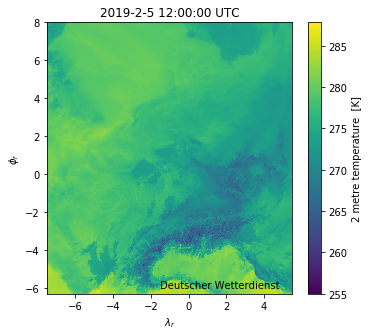

In [14]:
from matplotlib import pyplot

fig = pyplot.figure(figsize=(5.5, 5))

X, Y = numpy.meshgrid(rlon-360, rlat)
pyplot.pcolormesh(X, Y, t_2m[0,0,:,:])

pyplot.colorbar(label='%s  [%s]' %(t_2m_name, t_2m_unit))
pyplot.title('2019-2-5 12:00:00 UTC')
pyplot.xlabel('$\lambda_r$')
pyplot.ylabel('$\phi_r$')
pyplot.text(-1.5, -6, 'Deutscher Wetterdienst')

pyplot.savefig('2-metre-temp.png', dpi=300)

## Daten plotten mit CartoPy

- Community-Bibliothek, ursprünglich am UK MetOffice [entwickelt](https://scitools.org.uk/cartopy/docs/latest/)
- setzt auf [Matplotlib](http://matplotlib.org/) und [PROJ4](https://proj4.org/) auf
- unterstützt eine Vielzahl an [Kartenprojektionen](https://scitools.org.uk/cartopy/docs/latest/crs/projections.html)

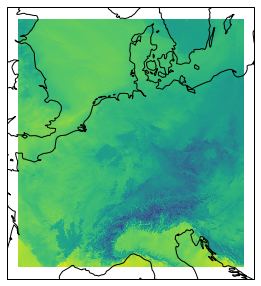

In [15]:
from cartopy import crs
from matplotlib import pyplot
import numpy

fig = pyplot.figure(figsize=(5,5))

cosmo_d2 = crs.RotatedPole(pole_longitude=-170, pole_latitude=40.)
ax = pyplot.axes(projection=cosmo_d2)
ax.coastlines('50m')
X, Y = numpy.meshgrid(rlon, rlat)
ax.pcolormesh(X, Y, t_2m[0,0,:,:])

## Projektion ändern

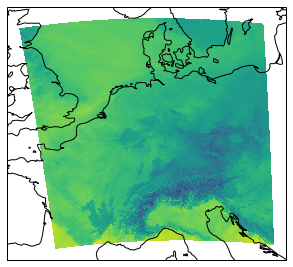

In [16]:
fig = pyplot.figure(figsize=(5,5))

cosmo_d2 = crs.RotatedPole(pole_longitude=-170, pole_latitude=40.)
mollweide = crs.Mollweide()

ax = pyplot.axes(projection=mollweide)
ax.coastlines('50m')
ax.pcolormesh(X, Y, t_2m[0,0,:,:], transform=cosmo_d2)

## Koordinatentransformation

...vom Ausgangskoordinatensystem `src_crs` in das Zielsystem `target_crs`:
- `x_t, y_t = target_crs.transform_point(x, y, src_crs)` — Punkt
- `x_t, y_t = target_crs.transform_points(src_crs, x, y)` — 1D und 2D Koordinatenfelder
- `u_t, v_t = target_crs.transform_vectors(src_crs, x, y, u, v)` — Vektoren

# Vielen Dank für Ihre Aufmerksamkeit!

**Eckhard Kadasch** (eckhard.kadasch@dwd.de),
Deutscher Wetterdienst, Zentrales Klimabüro

Diesen Vortrag finden Sie auf [bitbucket.com/eckhrd/dach2019-python-workshop](https://bitbucket.com/eckhrd/dach2019-python-workshop).

# Bonus

## Sprachgrundlagen

In [17]:
cities = ['London', 'Dublin', 'Oslo']
places_ive_seen = ['London', 'Berlin']

def visit(city):
    print("Welcome to " + city)
    
    if city in places_ive_seen:
        print("  - I've been here before.")

for city in cities:
    visit(city)

Welcome to London
  - I've been here before.
Welcome to Dublin
Welcome to Oslo


- *Blöcke durch Einrücken + ':'*
  - *Leerzeichen oder Tabs, aber konsistent*
- *Funktionen werden mit `()` aufgerufen.*

In [18]:
import numpy
a = numpy.array( [1.0, 2.0, 3.0, 4.0, 5.0, 6.0] )
a

array([1., 2., 3., 4., 5., 6.])

In [19]:
print( 'Min: %f  Max: %f  Mean: %f  Std. deviation: %f'
       %(a.min(), a.max(), a.mean(), a.std()) )

Min: 1.000000  Max: 6.000000  Mean: 3.500000  Std. deviation: 1.707825


- *Python ist eine objektorientierte, dynamisch typisierte Hoch-Sprache.*
- *Variablen sind Objekte und enthalten neben ihren Daten auch nützliche Funktionen.*

In [20]:
print( a[0] )
print( a[0:4] )
print( a[0:4:2] )

1.0
[1. 2. 3. 4.]
[1. 3.]


- *Sequenzen wie Listen oder NumPy-Arrays werden mit `[index]` indiziert.*
- *Die Indizierung beginnt mit 0.*
- *Slices werden definiert mit `[start:stop:step]`*
    - *`stop` wird ausgelassen.*

In [21]:
print(a + 0.5*a)

[1.5 3.  4.5 6.  7.5 9. ]


- *Numpy unterstützt effiziente Array-Operationen.*

## Weitere (wissenschaftliche) Bilbiotheken

In diesem Tutorial
- numpy
- matplotlib
- cartopy

Umfassende Standardbilbliothek (*"Batteries included"*)
- [datetime](https://docs.python.org/3/library/datetime.html) - Datumsarithmetik und -formattierung
- [re](https://docs.python.org/3/library/re.html) - reguläre Ausdrücke
- [sys](https://docs.python.org/3/library/sys.html) - u.a. Kommandozeilenargumente `sys.argv`
- [urllib](https://docs.python.org/3/library/urllib.html) - Zugriff auf das Internet

und viele wissenschaftliche Spezialbibliotheken
- [SciPy](https://docs.scipy.org/doc/scipy/reference/) -> `scipy.integrate, scipy.optimize, scipy.interpolate, scipy.fftpack, scipy.signal, scipy.linalg`
- [eofs](https://ajdawson.github.io/eofs/) - EOF Analyse (empirische orthogonale Funktionen)
- [pandas](http://pandas.pydata.org/) - effiziente Datenanalyse für Tabellen-Daten
- [xarray](http://xarray.pydata.org/en/stable/index.html) - n-dimensionale gelabelte Arrays
- [Numba](https://numba.pydata.org/) - beschleunigt Python durch Just-in-time Kompilierung

